# Problem set 4: APIs, SQL, and supervised machine learning

**Total points (without extra credit)**: 48 


## Resources from class

### APIs
- [Lecture slides](https://docs.google.com/presentation/d/1eblPOhpOL1HDFk3XOh3KvcrFceJ4pwZNUU_fvU8i7uo/edit#slide=id.p)
- [Activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/06_apis_solutions.ipynb)


### Supervised ML
- [Lecture slides 1](https://docs.google.com/presentation/d/1V6X9aYkYLvyh3Ea0ZSn3qkttqKz7OOPkfvbqYybMi5Q/edit#slide=id.p)
- [Lecture slides 2](https://docs.google.com/presentation/d/13xJTI_GZ2HZYI9OSmezwLUXXFxIrjwHXKz50QUjBF0w/edit)
- [Intro activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/08_ML_intro_activity_solutions.ipynb)
- [Part II activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/08_ML_optimization_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/supervised-learning-with-scikit-learn)

### SQL
- [Lecture slides](https://docs.google.com/presentation/d/1HHgrkFtuhGIaPNMd1EOiM-8VtgnF0cwjMcmah8oWmWA/edit?usp=sharing)
- [Example code](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/09_SQL_examplecode.ipynb)
- [Activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/09_SQL_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/introduction-to-sql)

# Prep work: change SQL dataset

- Place it in [the same credentials yaml file on GitHub that contains the SQL database access information](https://github.com/herbertfreeze/QSS_public/blob/main/activities/09_db_cred.yaml) (password, host, etc.) 
    - Name the combined credentials file something appropriate (feel free to get creative)
    - Change the database name from `sentencing` to `math_gencompare`

## 0.0 Import packages

**Note you need to install some of the packages imported below (see the comments).**

In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import matplotlib.pyplot as plt
import yaml
#import warnings
#warnings.filterwarnings("ignore")

## note: you may need to install these using !pip install
# !pip install census
# !pip install us
import census
from census import Census
import us
from us import states
import mysql.connector

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)



/Users/vaanigupta/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# 1. Write a wrapper function to pull data from the NAEP API (12 points)

In the class activity on APIs (see link above), we practiced pulling from the API for the National Assessment of Educational Progress (NAEP), "America's report card" of test scores. We pulled a small amount of data at the national level (writing scores by gender) using a query where the parameters were hardcoded.
    
In this problem, we'll practice pulling a larger set of data and writing a wrapper function.
    
As a reminder, the documentation is here: https://www.nationsreportcard.gov/api_documentation.aspx

The base link is: https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx

## 1.1 Write a query to pull 8th-grade mathematics scores in 2015 from the state of California (CA) by gender (1 point)

- Subject: mathematics 
- Subscale: MRPCM composite scale 
- Grade: 8
- Year: 2015
- grouping variable: GENDER 
- Jurisdiction: CA 
- stattype = MN (for mean)

Print the output in dataframe format and briefly interpret; what do scores look like between the genders?

In [2]:
# your code here
base_url = "https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?"

In [3]:
scores_query = base_url + "type=data&subject=mathematics&subscale=MRPCM&grade=8&Year=2015&variable=GENDER&jurisdiction=CA&stattype=MN:MN"
scores_response = requests.get(scores_query)
scores_df = pd.DataFrame(scores_response.json()['result'])
scores_df

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,275.020977,1,0
1,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,275.638637,1,0


### Average scores for both genders are similar, but females have the slightly higher score. Females have an average score of 275.64, while males have an average score of 275.02 in 2015 (difference of roughly 0.6).

## 1.2 Write a query to pull 8th-grade mathematics scores in 2013, 2015, 2017, and 2019 from California by gender (1 point)

Same as 1.1 but pull the years 2013, 2015, 2017, and 2019 (search documentation for how to combine) in one query

In [4]:
# your code here
scores_years_query = base_url + "type=data&subject=mathematics&subscale=MRPCM&grade=8&Year=2013,2015,2017,2019&variable=GENDER&jurisdiction=CA&stattype=MN:MN"
scores_years_response = requests.get(scores_years_query)
scores_years_df = pd.DataFrame(scores_years_response.json()['result'])
scores_years_df

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,274.597824,1,0
2,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,275.020977,1,0
3,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,275.638637,1,0
4,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,276.608704,1,0
5,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,276.669430,1,0
6,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,274.511628,1,0
7,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,276.721824,1,0


## 1.3 Create a line plot to show variation in the scores across years (2 points)

Using the results from 1.2, create a plot where the x axis has the year and the y axis is the math scores (`value` in dataframe), and there are separate lines/colors for male versus female students (`varValueLabel` in dataframe)

Start the limits of the y axis minimum at 272 and add informative labels. Be sure your x-axis is ticked on odd years, because NAEP scores skip even years. 

(272.0, 277.29994776969266)

([<matplotlib.axis.XTick at 0x7faae8a82850>,
 [Text(2013, 0, '2013'),
  Text(2015, 0, '2015'),
  Text(2017, 0, '2017'),
  Text(2019, 0, '2019')])

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Math Scores')

Text(0.5, 1.0, 'Male and Female Grade 8 Math Scores in CA: 2013-2019')

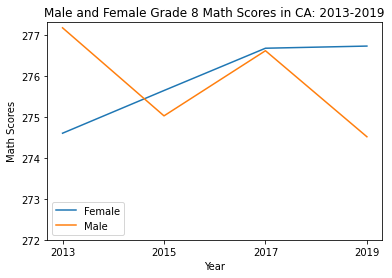

In [5]:
# your code here
years_list = scores_years_df["year"].unique()
indicator = scores_years_df["varValueLabel"] == "Female"
plt.plot(years_list, scores_years_df[indicator]["value"], label="Female")
plt.plot(years_list, scores_years_df[~indicator]["value"], label="Male")
plt.ylim([272, None])
plt.xticks(years_list)
plt.xlabel('Year')
plt.ylabel('Math Scores')
plt.title('Male and Female Grade 8 Math Scores in CA: 2013-2019')
plt.legend()
plt.show()

## 1.4 Reproduce the queries from 1.1 and 1.2 using a user-defined function (4 points)

Create a function, `construct_naep_query` that takes in two arguments:

- year: this should be a list with all years (so if one year, single element list; if multiple years, list with those years)
- place: this should be a string with the name of the state or jurisdiction to pull 
    
Have the function return the query and make sure it's identical to the queries you wrote for 1.1 and 1.2 (can use assert or other checker)

In [6]:
# your code here to define function
def construct_naep_query(years, place):
    years_string = ','.join(years)
    query = base_url + "type=data&subject=mathematics&subscale=MRPCM&grade=8&Year=" + years_string + "&variable=GENDER&jurisdiction=" + place + "&stattype=MN:MN"
    return query    

In [7]:
# your code here to execute function
# 1.1 
scores_query_func = construct_naep_query(["2015"], "CA")
print(scores_query_func)
assert scores_query == scores_query_func, f"Strings are not identical: '{scores_query}' != '{scores_query_func}'"

# 1.2
years_list = ["2013", "2015", "2017","2019"]
scores_years_query_func = construct_naep_query(years_list, "CA")
print(scores_years_query_func)
assert scores_years_query == scores_years_query_func, f"Strings are not identical: '{scores_years_query}' != '{scores_years_query_func}'"

https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&subscale=MRPCM&grade=8&Year=2015&variable=GENDER&jurisdiction=CA&stattype=MN:MN
https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&subscale=MRPCM&grade=8&Year=2013,2015,2017,2019&variable=GENDER&jurisdiction=CA&stattype=MN:MN


## 1.5 Write and execute user-defined function that takes in a query and returns a pandas dataframe with the content of the response (4 points)

- Write a user-defined function (`process_naep_query`) that takes in the CA-specific NAEP query as a string, calls the API, and transforms the response into a pandas dataframe. Have the function return that pandas dataframe

- Make sure the function is flexible enough to handle queries that return an error; for queries that return an error, have the function return the string "Data not found; check your query" (see [API part 1 solutions code](https://github.com/herbertfreeze/QSS_public/blob/main/activities/solutions/06_apis_solutions.ipynb) for an example of `try:`/`except:`)

- Execute the function on the query that pulls 2013-2019 data (either from handwriting the query or the result in 1.4)

- Print the resulting dataframe

- Then execute the function on a query that pulls a state that doesn't exist (call this state ZZ)

In [8]:
# your code here
def process_naep_query(query):    
    try:
        response = requests.get(query)
        scores_df = pd.DataFrame(response.json()['result'])
        return scores_df
        
    except Exception as e:
            print("Data not found; check your query")

In [9]:
scores_years_df_func = process_naep_query(scores_years_query_func)
scores_years_df_func

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,274.597824,1,0
2,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,275.020977,1,0
3,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,275.638637,1,0
4,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,276.608704,1,0
5,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,276.669430,1,0
6,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,274.511628,1,0
7,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,276.721824,1,0


In [10]:
error_query = construct_naep_query(years_list, "ZZ")
process_naep_query(error_query)

Data not found; check your query


# 2. Explore data using SQL queries (18 points)

In the previous example, you worked with the data in a flat file and manipulated it using pandas. Here, we're going to practice running queries to do some calculations using SQL --- in the case of our data, this is a bit overkill since the data are small but it is practice for larger datasets.

## 2.1 Load database credentials and establish a connection (1 point)

Load a credentials file that contains the credentials you'll need for this and the next problem:

- The credentials for our class database
- The credentials for the Census API (see instructions above)

Note: to establish the SQL connection, you need to be on `eduroam` (near campus) or the Dartmouth's GlobalProtect `VPN`  ([installation instructions here](https://services.dartmouth.edu/TDClient/1806/Portal/KB/ArticleDet?ID=72395))

In [11]:
creds = load_creds("PATH TO YOUR CREDS FILE")

FileNotFoundError: [Errno 2] No such file or directory: 'PATH TO YOUR CREDS FILE'

## 2.2 Run a query to select all columns and the first 5 rows of the math_gencompare database to explore structure (2 points)

Read the results in as a pandas dataframe and print the result

In [ ]:
# your code here

## 2.3 Find the (1) number of rows in the database, (2) number of distinct states,  (3) number of distinct years (3 points)

Interpret the results - how do you think the data is structured in terms of states and years (eg long format where each state repeated; wide format)?

**Hint**: rather than using count `(*)` for the latter two, think about the `distinct` command in combination with `count`: https://www.w3resource.com/mysql/aggregate-functions-and-grouping/aggregate-functions-and-grouping-count-with-distinct.php

In [ ]:
# your code here

## 2.4 Construct a new variable, `is_male_higher` that takes the value of 1 if the math scores of males exceed that of females in that state and year (each row) (2 points)

Read in the results, print the head, and find the mean across all rows (the percentage of state-years where male students have higher scores)

In [ ]:
# your code here

## 2.5 group by year and find the percentage of states where male scores are higher than females (4 points)

**A.** Write a query that (1) groups by year and (2) finds the percentage of states that have higher scores for males than females in this year 

**B.** Print the resulting dataframe and interpret the results 

**Hint:** To compare male and female scores, consider logical operators (e.g., `<`, `>`, `=`) and simple aggregation (e.g., `avg()` to get mean) or using a subquery to construct the indicator.

In [ ]:
# your code here

## 2.6 group by state and find the percentage of years where male scores higher than females

**A.** Write a query that (1) groups by state and (2) finds the percentage of years that have higher scores for males than females in that state

**B.** Plot the results ordering the states from males higher all 4 years to males higher none of the years

In [ ]:
# your code here

## 2.7 Use a subquery to create an indicator and group by that indicator (6 points)

The following states were the first 6 to expand the right to vote to women before the uniform federal expansion in 1920

- Wyoming 1890
- Colorado 1893
- Utah 1896
- Idaho 1896
- Washington 1910
- California 1911

**A.** Create an indicator `is_early_voter` for whether a state is in that list or not; do so without typing the state names inside the string and instead collapsing the list of states we provide and using something like `format`. Hint on how to combine the state names while preserving the quotes around each: https://stackoverflow.com/questions/12007686/join-a-list-of-strings-in-python-and-wrap-each-string-in-quotation-marks 

**B.** Then, group by the `is_early_voter` indicator and `year` and find the percencentage of states in each group where males had higher scores than females 

**C.** Print the resulting dataframe and interpret. Does early expansion of voting seem to be correlated with girls scoring better on the math tests a century later?

**Hint:** in order to group by the indicator in step b, you may need to use a subquery 

In [ ]:
## list of states we provide
list_suffrage = ["Wyoming", "Colorado", "Utah", "Idaho", "Washington", 
                "California"]


In [ ]:
## your code here


# 3. Explore variation in math score disparities and trends (18 points)

## 3.0 Read in the `acs_wmath.pkl` file (csv is backup) (0 points)

In [12]:
## your code here
acs_df = pd.read_pickle("../../public_data/acs_wmath.pkl")
acs_df.head()

,math_female_2013,math_female_2015,math_female_2017,math_female_2019,math_male_2013,math_male_2015,math_male_2017,math_male_2019,abbrev,FIPS,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated more than 0 to less than 10 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated no income allocated,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal10th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal11th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal12th grade no diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal1st grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal2nd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal3rd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal4th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal5th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal6th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal7th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal8th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal9th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalassociate's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalbachelor's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotaldoctorate degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalged or alternative credential,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalkindergarten,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalmaster's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalno schooling completed,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalnursery school,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalprofessional school degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalregular high school diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college 1 or more years no degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college less than 1 year,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin group quarters,acspredict_household_type__including_living_alone__by_relationshipestimatetot

## 3.1 Create a visualization where one axis is the state; the other axis is the male 2013 math scores - the female 2013 math scores (gender disparity) (2 points)


You have free rein over additional details but make sure it is informative over what direction of disparity positive versus negative values mean


<Figure size 1008x576 with 0 Axes>

<BarContainer object of 50 artists>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'Alaska'),
  Text(1, 0, 'Alabama'),
  Text(2, 0, 'Arkansas'),
  Text(3, 0, 'Arizona'),
  Text(4, 0, 'California'),
  Text(5, 0, 'Colorado'),
  Text(6, 0, 'Connecticut'),
  Text(7, 0, 'Delaware'),
  Text(8, 0, 'Florida'),
  Text(9, 0, 'Georgia'),
  Text(10, 0, 'Hawaii'),
  Text(11, 0, 'Iowa'),
  Text(12, 0, 'Idaho'),
  Text(13, 0, 'Illinois'),
  Text(14, 0, 'Indiana'),
  Text(15, 0, 'Kansas'),
  Text(16, 0, 'Kentucky'),
  Text(17, 0, 'Louisiana'),
  Text(18, 0, 'Massachusetts'),
  Text(19, 0, 'Maryland'),
  Text(20, 0, 'Maine'),
  Text(21, 0, 'Michigan'),
  Text(22, 0, 'Minnesota'),
  Text(23, 0, 'Missouri'),
  Text(24, 0, 'Mississippi'),
  Text(25, 0, 'Montana'),
  Text(26, 0, 'North Car

Text(0.5, 0, 'State')

Text(0, 0.5, 'Gender Disparity (Male Math Score - Female Math Score)')

Text(0.5, 1.0, 'Gender Disparity in 2013 Math Scores across States')

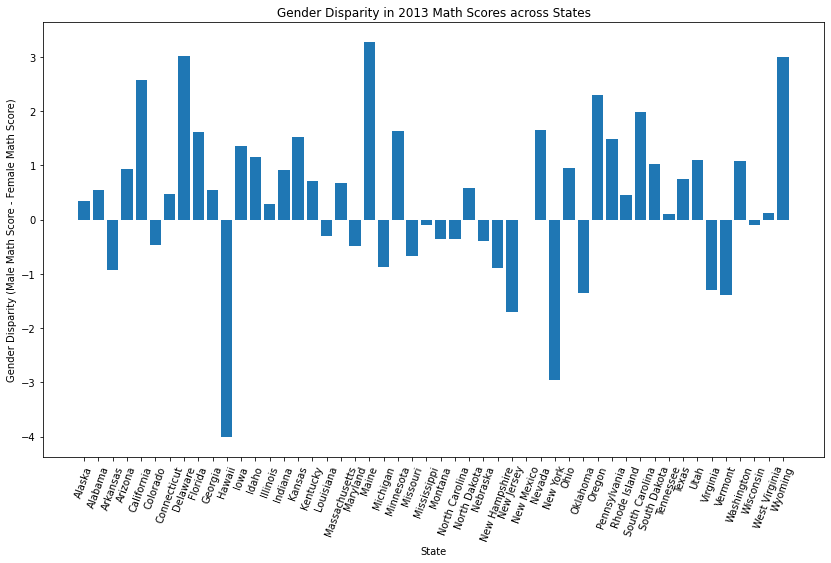

In [13]:
## your code here
gender_disparity = acs_df["math_male_2013"] - acs_df["math_female_2013"]
plt.figure(figsize = (14,8))
plt.bar(acs_df["state"], gender_disparity)
plt.xticks(rotation=70)
plt.xlabel('State')
plt.ylabel('Gender Disparity (Male Math Score - Female Math Score)')
plt.title('Gender Disparity in 2013 Math Scores across States')

## 3.2 Examine gender disparity in relation to household income (6 points)

**A.** Construct an indicator variable for the state having better performance of males in 2013 than females

**B.** First plot a scatterplot (or seaborn regplot) of estimated median household income from the acs data (we provide varname below) vs `math_male_2013`. Then do a second smoothed scatterplot for median household income vs `math_female_2013`.

**C.** 
Then use the `np.corrcoef` command (three separate times) to examine the bivariate correlation of
- male performance
- female performance
- the indicator variable from **A** 

with median household income (`acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars`)

Documentation: https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

**D.** Interpret the correlations - in states with higher median household income (MHI), do 
   - boys tend to perform better than boys in states with lower MHI?
   - girls tend to perform better than girls in states with lower MHI?
   - boys tend to outperform girls more than they do in states with lower MHI?

In [14]:
# your code here
# Part A
male_performance = gender_disparity > 0 

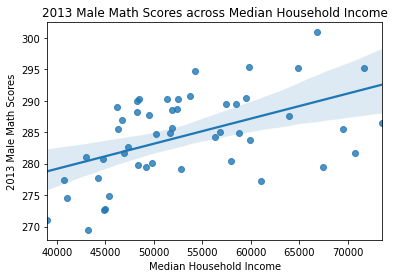

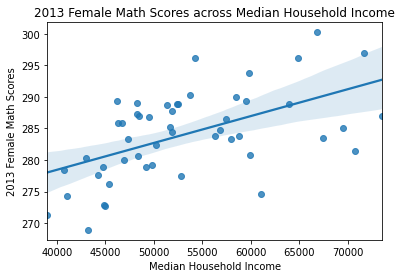

In [15]:
### Part B
import seaborn as sns
def create_gendered_plot(gender):
    y = "math_" + gender + "_2013"
    y_title = '2013 ' + gender.capitalize() + ' Math Scores'
    title = '2013 ' + gender.capitalize() + ' Math Scores across Median Household Income'
    sns.regplot(x= "acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars", 
               y = y, data=acs_df)
    plt.xlabel('Median Household Income')
    plt.ylabel(y_title)
    plt.title(title)
    plt.show()

# male
create_gendered_plot("male")

# female
create_gendered_plot("female")

In [16]:
# Part C
corr_male = np.corrcoef(acs_df["math_male_2013"], acs_df["acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars"])
print(corr_male)
corr_female = np.corrcoef(acs_df["math_female_2013"], acs_df["acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars"])
print(corr_female)
corr_indicator = np.corrcoef(male_performance, acs_df["acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars"])
print(corr_indicator)

[[1.         0.50734719]
 [0.50734719 1.        ]]
[[1.         0.54337803]
 [0.54337803 1.        ]]
[[ 1.        -0.0338752]
 [-0.0338752  1.       ]]


### Part D: 
### Boys tend to perform better than boys in states with lower MHI as indicated by the positive correlation (0.507) between male math scores and median household income. 
### Girls tend to perform better than girls in states with lower MHI as indicated by the positive correlation (0.543) between female math scores and median household income. 
### Boys do not tend to outperform girls more than they do in states with lower MHI as indicated by the negative correlation (-0.0339) between the indicator and median household income. 

## 3.3 Predicting disparities (10 points)

**A.** Read in the raw `acs_wmath` data again (this loses the variables you created above)

**B.** Construct a binary indicator variable for male score > female score  for each year - for full credit, do so without repeating the difference code for each of the four years: name these according to following convention: `outcome_male_higher_female_year` where year is 2013, 2015, 2017, or 2019 (e.g., 2013: `outcome_male_higher_female_2013`). After this, remove the raw math scores as columns in the data (so filter out any column with the word math)

**C.** Melt the data (`acs_wmath`) to long where instead of wide years, years are repeated within state; the ACS vars will also be repeated since we only pulled one year. In other words, reshape the data from "wide format", where each state is a row and we have separate columns for each year, to "long format", where states are repeated four times: once for each year in the data (2013, 2015, 2017, 2019). With 50 states, your final shape should be (200,84).
- See: https://pandas.pydata.org/docs/reference/api/pandas.melt.html

**D.** Split into train-test split at state level (so all years in same state -> either all in train or all test). Randomize 35 states to train; 15 states in test. 

**E.** Normalize the features to mean 0, variance 1 and estimate a decision tree with a max depth of 5. Your covariates should have the term 'acspredict' in it.

- **Hint:** The ML literature recommends using the training set scaler to transform the test set, rather than using a unique scaler to initialize each one. The reasons are discussed here: https://stats.stackexchange.com/questions/495357/why-do-we-normalize-test-data-on-the-parameters-of-the-training-data

**F.** Interpret the feature importances

**G.** Evaluate the precision and recall of that model in the test set states without using the `score`, `precision`, or `recall` functions in sklearn. Briefly interpret: compared to our class example (a high-dimensional feature matrix of yelp reviews with ~15000 observations), why do you think our models perform worse for this set of data/predictors?

**Additional resources:** 

- Feature normalization: https://scikit-learn.org/stable/modules/preprocessing.html

- Definition of precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall

In [50]:
# A. your code here to load data
acs_wmath = pd.read_pickle("../../public_data/acs_wmath.pkl")

In [51]:
# B. your code here to construct binary indicators for male higher
def get_performance_indicator(year):
    male_col = "math_male_" + year
    female_col = "math_female_" + year
    gender_disparity = acs_wmath[male_col] - acs_wmath[female_col]
    col_name = "outcome_male_higher_female_" + year
    acs_wmath[col_name] = gender_disparity > 0

years_list = ["2013", "2015", "2017","2019"]
for year in years_list:
    get_performance_indicator(year)

cols = acs_wmath.columns.to_list()
print(len(cols))
cols = [c for c in cols if "math" not in c]
print(len(cols))
acs_wmath = acs_wmath[cols]
print(acs_wmath.shape)
acs_wmath.head()

96
88
(50, 88)


,abbrev,FIPS,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated more than 0 to less than 10 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated no income allocated,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal10th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal11th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal12th grade no diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal1st grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal2nd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal3rd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal4th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal5th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal6th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal7th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal8th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal9th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalassociate's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalbachelor's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotaldoctorate degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalged or alternative credential,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalkindergarten,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalmaster's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalno schooling completed,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalnursery school,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalprofessional school degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalregular high school diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college 1 or more years no degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college less than 1 year,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin group quarters,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin households,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family households

In [48]:
# C. your code here to melt data
# have 2 additional columns variable and value -- do we drop this-- if so, then how do we know which year the row represents?
years_list = ["2013", "2015", "2017", "2019"]
years_cols = [col for col in acs_wmath.columns for year in years_list if year in col]
other_cols = [col for col in acs_wmath.columns if col not in years_cols]
df_melted = pd.melt(acs_wmath, id_vars=other_cols, 
                        value_vars=years_cols)
df_melted.shape
df_melted.head()

(200, 86)

,abbrev,FIPS,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated more than 0 to less than 10 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated no income allocated,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal10th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal11th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal12th grade no diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal1st grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal2nd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal3rd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal4th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal5th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal6th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal7th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal8th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal9th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalassociate's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalbachelor's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotaldoctorate degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalged or alternative credential,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalkindergarten,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalmaster's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalno schooling completed,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalnursery school,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalprofessional school degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalregular high school diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college 1 or more years no degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college less than 1 year,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin group quarters,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin households,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family households

In [ ]:
# D. your code here for train/test split

In [ ]:
# E. your code here to normalize features and fit model

In [ ]:
# F. your code here to interpret feature importances

In [ ]:
# G. your code here to evaluate model